# Logistic Regression and SGD Homework 
***
**Name**: $<$Rajarshi Basak$>$ 
***

This assignment is due on Moodle by **5pm on Friday February 9th**. Submit only this Jupyter notebook to Moodle.  Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)


## Overview 
***


In this homework you'll implement stochastic gradient ascent for logistic regression and you'll apply it to the task of determining whether documents are talking about automobiles or motorcycles.

<br>

![autos_motorcycles](autos_motorcycles.jpg "A car and a motorcycle")


<br>

You should not use any libraries that implement any of the functionality of logistic regression for this assignment; logistic regression is implemented in Scikit-Learn, but you should do everything by hand now. You'll be able to use library implementations of logistic regression in the future.

Here are the rules: 

- Do **NOT** load or use any Python packages that are not available in Anaconda 3.6. 
- Some problems with code may be autograded.  If we provide a function or class API **do not** change it.
- Do not change the location of the data or data directory.  Use only relative paths to access the data. 

In [226]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline 

import math
from collections import defaultdict

### [5 points] Problem 1: Loading and Exploring the Data
***

The `Example` class will be used to store the features and labels associated with a single training or test example.  The `read_data` function will read in the text data and split it into training and test sets.  

 Load the data and then do the following: 
- Report the number of words in the vocabulary 
- Explain how the code is creating features (i.e. what text model is being used). 
- Go into the raw text files in the data directory and figure out which label (0/1) refers to which class of document (automobiles or motorcycles)

In [227]:
kSEED = 1735
kBIAS = "BIAS_CONSTANT"

np.random.seed(kSEED)

class Example:
    """
    Class to represent a document example
    """
    def __init__(self, label, words, vocab):
        """
        Create a new example

        :param label: The label (0 / 1) of the example
        :param words: The words in a list of "word:count" format
        :param vocab: The vocabulary to use as features (list)
        """
        self.nonzero = {}
        self.y = label
        self.x = np.zeros(len(vocab))
        for word, count in [x.split(":") for x in words]:
            if word in vocab:
                assert word != kBIAS, "Bias can't actually appear in document"
                self.x[vocab.index(word)] += float(count)
                self.nonzero[vocab.index(word)] = word
        self.x[0] = 1

def read_dataset(positive, negative, vocab, train_frac=0.9):
    """
    Reads in a text dataset with a given vocabulary

    :param positive: Positive examples
    :param negative: Negative examples
    :param vocab: A list of vocabulary words
    :param test_frac: How much of the data should be reserved for test
    """

    vocab = [x.split("\t")[0] for x in open(vocab, 'r') if '\t' in x]
    assert vocab[0] == kBIAS, \
        "First vocab word must be bias term (was %s)" % vocab[0]

    train_set = []
    test_set = []
    for label, input in [(1, positive), (0, negative)]:
        for line in open(input):
            ex = Example(label, line.split(), vocab)
            if np.random.random() <= train_frac:
                train_set.append(ex)
            else:
                test_set.append(ex)

    # Shuffle the data 
    np.random.shuffle(train_set)
    np.random.shuffle(test_set)

    return train_set, test_set, vocab

In [228]:
pos_fname = "../data/autos_motorcycles/positive"
neg_fname = "../data/autos_motorcycles/negative"
voc_fname = "../data/autos_motorcycles/vocab"
train_set, test_set, vocab = read_dataset(pos_fname, neg_fname, voc_fname)

**Problem 1 Solutions :** 

In [229]:
print ("The number of words in the vocabulary is" ,len(vocab))

The number of words in the vocabulary is 5327


**(b)** The code is creating features using the 'Bag of Words' model. In this text model, we set an entry of the vector equal to the frequency with which the word appears in the entire document.

**(c)** By exploring the raw text files in the data directory (positive_raw and negative_raw), it can be concluded that the label 0 refers to the automobiles class of document, and the label 1 refers to the motorbikes class of document.

### [25 points] Problem 2: Implementing SGD with Lazy Sparse Regularization
***

We've given you a class `LogReg` below which will train a logistic regression classifier to predict whether a document is talking about automobiles or motorcycles. 

**Part A**: In this problem you will modify the `sgd_update` function to perform **unregularized** stochastic gradient descent updates of the weights. Note that you should only update the weights for **non-zero** features, i.e. weights associated with words that appear in the current training example. The code below this cell demonstrates how to instantiate the class and train the classifier.   

We've also given you unit tests in the next cell based on the simple example worked out in  the Lecture 4 in-class notebook.  At first your code will fail both of them. When your code is working you should pass tests called `test_unreg` and `test_learnrate`.  Do not move on to **Part A** until your code passes both of them. 

In [230]:
class LogReg:
    def __init__(self, train_set, test_set, lam, eta=0.1):
        """
        Create a logistic regression classifier

        :param train_set: A set of training examples
        :param test_set: A set of test examples 
        :param lam: Regularization parameter
        :param eta: The learning rate to use 
        """
        
        # Store training and test sets 
        self.train_set = train_set
        self.test_set = test_set 
        
        # Initialize vector of weights to zero  
        self.w = np.zeros_like(train_set[0].x)
        
        # Store regularization parameter and eta function 
        self.lam = lam
        self.eta = eta
        
        # Create dictionary for lazy-sparse regularization
        self.last_update = defaultdict(int)

        # Make sure regularization parameter is not negative 
        assert self.lam>= 0, "Regularization parameter must be non-negative"
        
        # Empty lists to store NLL and accuracy on train and test sets 
        self.train_nll = []
        self.test_nll = []
        self.train_acc = []
        self.test_acc = []
        self.iterationcount = [] 
      
    def sigmoid(self,score, threshold=20.0):
        """
        Prevent overflow of exp by capping activation at 20.
        You do not need to change this function. 

        :param score: A real valued number to convert into a number between 0 and 1
        """

        # if score > threshold, cap value at score 
        if abs(score) > threshold:
            score = threshold * np.sign(score)

        return 1.0 / (1.0 + np.exp(-score)) 

    def compute_progress(self, examples):
        """
        Given a set of examples, compute the NLL and accuracy
        You shouldn't need to change this function. 

        :param examples: The dataset to score
        :return: A tuple of (log probability, accuracy)
        """

        NLL = 0.0
        num_correct = 0
        for ex in examples:
            # compute prob prediction
            p = self.sigmoid(self.w.dot(ex.x))
            # update negative log likelihood
            NLL = NLL - np.log(p) if ex.y==1 else NLL - np.log(1.0-p)
            # update number correct 
            num_correct += 1 if np.floor(p+.5)==ex.y else 0

        return NLL, float(num_correct) / float(len(examples))
    
    def train(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.train_set)
            # loop over each training example
            for ex in self.train_set:
                # perform SGD update of weights
                iteration += 1
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    self.iterationcount.append(iteration)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration, train_nll, test_nll, train_acc, test_acc))
    
    #Function for testing similar to that for training
    def tester(self, num_epochs=1, isVerbose=False, report_step=5):
        """
        Train the logistic regression classifier on the training data 

        :param num_epochs: number of full passes over data to perform 
        :param isVerbose: boolean indicating whether to print progress
        :param report_step: how many iterations between recording progress
        """
        iteration = 0
        # Perform an epoch 
        for pp in range(num_epochs):
            # shuffle the data  
            np.random.shuffle(self.test_set)
            # loop over each training example
            for ex in self.test_set:
                # perform SGD update of weights
                iteration += 1
                self.sgd_update(ex, iteration)
                # record progress 
                if iteration % report_step == 1:
                    train_nll, train_acc = self.compute_progress(self.train_set)
                    test_nll, test_acc = self.compute_progress(self.test_set)
                    self.train_nll.append(train_nll)
                    self.test_nll.append(test_nll)
                    self.train_acc.append(train_acc)
                    self.test_acc.append(test_acc)
                    self.iterationcount.append(iteration)
                    if isVerbose:
                        print("Update {: 5d}  TrnNLL {: 8.3f}  TstNLL {: 8.3f}  TrnA {:.3f}  TstA {:.3f}"
                             .format(iteration, train_nll, test_nll, train_acc, test_acc))
                
                
    
    def sgd_update(self, train_example, iteration, use_tfidf=False):
        """
        Compute a stochastic gradient update to improve the log likelihood.
        :param train_example: The example to take the gradient with respect to
        :param iteration: The current iteration (an integer)
        :param use_tfidf: A boolean to switch between the raw data and the tfidf representation
        :return: Return the new value of the regression coefficients
        """
        
        xs = train_example.x
        ys = train_example.y
        
        #Unregularized SGD weight update
        
        #Get the non-zero entries from the training set
        nz = list(train_example.nonzero.keys())
        #Add a 0 for the first entry
        nz.append(0)
        
        #take the dot product of the transpose of the weight vector with the non-zero entries from the training set
        wdott = math.exp(self.w[nz].dot(xs[nz]))
        #take the sigmoid of the above value
        p = wdott/float(1+wdott)
        #update the weight vector
        self.w[nz] = self.w[nz] + ((self.eta) * (ys - p) * xs[nz])
        biasur = self.w[0] 
        
        #Lazy sparse regularization
        for k in range(0, len(self.w)):
            self.last_update[k] += 1
        lsr = np.power((1 - (2 * self.eta * self.lam)),((list(self.last_update.values()))))
        self.w[nz] = self.w[nz] * lsr[nz]
        
        self.w[0] = biasur
        for j in nz:
            self.last_update[j]=0
            
    def bestpredmotor(self):
        bestmotor = np.argsort(self.w)[-10:]
        return (bestmotor)
    
    def bestpredauto(self):
        bestauto = np.argsort(self.w)[:10]
        return (bestauto)
    
    def worstpred(self):
        worst = np.argsort(abs(self.w))[:10]
        return (worst)

In [231]:
lr = LogReg(train_set, test_set, lam=0, eta=0.1)
lr.train(isVerbose=True)

Update     1  TrnNLL  733.374  TstNLL   77.686  TrnA 0.498  TstA 0.534
Update     6  TrnNLL  702.189  TstNLL   69.875  TrnA 0.612  TstA 0.612
Update    11  TrnNLL  3777.298  TstNLL  372.528  TrnA 0.507  TstA 0.552
Update    16  TrnNLL  3492.784  TstNLL  341.889  TrnA 0.518  TstA 0.552
Update    21  TrnNLL  2910.957  TstNLL  283.324  TrnA 0.533  TstA 0.569
Update    26  TrnNLL  2428.802  TstNLL  240.894  TrnA 0.560  TstA 0.586
Update    31  TrnNLL  1508.144  TstNLL  155.311  TrnA 0.652  TstA 0.629
Update    36  TrnNLL  1409.754  TstNLL  147.484  TrnA 0.662  TstA 0.647
Update    41  TrnNLL  612.994  TstNLL   83.984  TrnA 0.796  TstA 0.767
Update    46  TrnNLL  464.616  TstNLL   59.366  TrnA 0.845  TstA 0.819
Update    51  TrnNLL  454.871  TstNLL   57.384  TrnA 0.846  TstA 0.819
Update    56  TrnNLL  446.542  TstNLL   57.480  TrnA 0.843  TstA 0.819
Update    61  TrnNLL  431.802  TstNLL   54.360  TrnA 0.853  TstA 0.819
Update    66  TrnNLL  431.629  TstNLL   54.258  TrnA 0.853  TstA 0.819


Update   626  TrnNLL  137.314  TstNLL   21.716  TrnA 0.958  TstA 0.914
Update   631  TrnNLL  136.155  TstNLL   21.650  TrnA 0.958  TstA 0.914
Update   636  TrnNLL  133.045  TstNLL   21.577  TrnA 0.959  TstA 0.914
Update   641  TrnNLL  132.809  TstNLL   21.564  TrnA 0.959  TstA 0.914
Update   646  TrnNLL  131.986  TstNLL   21.628  TrnA 0.959  TstA 0.914
Update   651  TrnNLL  129.429  TstNLL   21.864  TrnA 0.959  TstA 0.914
Update   656  TrnNLL  128.923  TstNLL   21.803  TrnA 0.959  TstA 0.914
Update   661  TrnNLL  133.679  TstNLL   20.800  TrnA 0.961  TstA 0.914
Update   666  TrnNLL  131.584  TstNLL   20.875  TrnA 0.959  TstA 0.922
Update   671  TrnNLL  131.562  TstNLL   20.887  TrnA 0.959  TstA 0.922
Update   676  TrnNLL  131.648  TstNLL   20.923  TrnA 0.959  TstA 0.922
Update   681  TrnNLL  131.768  TstNLL   20.848  TrnA 0.960  TstA 0.922
Update   686  TrnNLL  127.836  TstNLL   21.624  TrnA 0.959  TstA 0.914
Update   691  TrnNLL  127.834  TstNLL   21.624  TrnA 0.959  TstA 0.914
Update

The unit tests are located in the script `tests.py` in this directory.  Execute the following cell to call the script and run the tests. 

In [232]:
%run -i tests.py "part A"

test_unreg (__main__.TestLogReg) ... ok
test_learnrate (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.006s

OK


**Part B**: After your unregularized updates are working, modify the `sgd_update` function again to perform regularized updates using **Lazy Sparse Regularization**. Note that you should not regularize the bias weight. See the Lecture 4 in-class notebook for a refresher on LSR. **Note**: After implementing LSR, your code should still pass the unit tests for **Part A** when `lam = 0`. 

We've given you a third unit test in the next cell called `test_reg` based on the simple example of LSR worked out in  the Lecture 4 in-class notebook.  Do not move on to **Problem 3** until your code passes the test. 

In [233]:
%run -i tests.py "part B"

test_reg (__main__.TestLogReg) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### [10 points] Problem 3: Hyperparameter Tuning 
***

**Part A**: Perform a systematic study of the effect of the regularization parameter on the accuracy of your classifier on the test set.  Which choice of `lam` seems to do the best?  Justify your conclusion with some kind of graphic. 

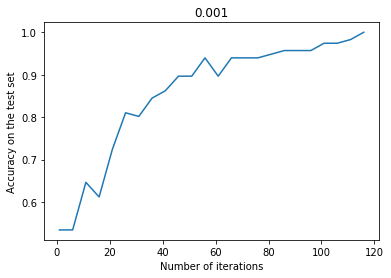

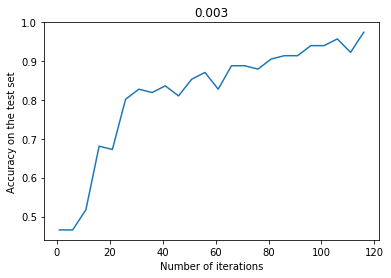

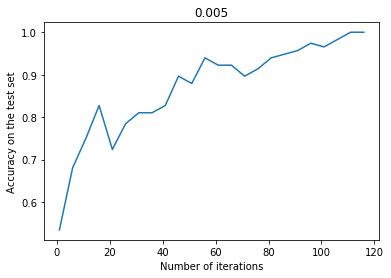

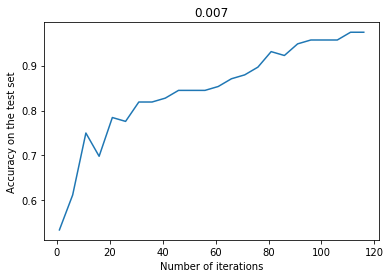

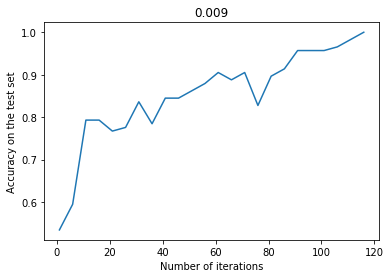

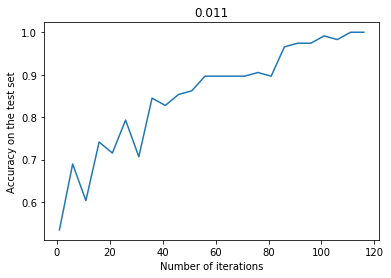

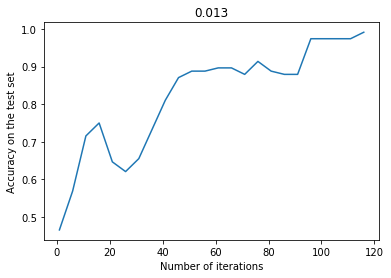

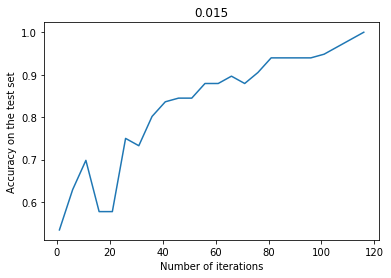

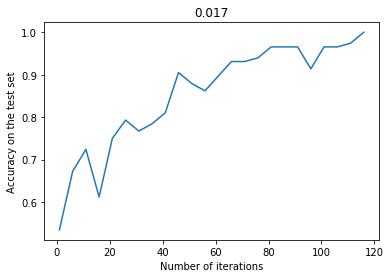

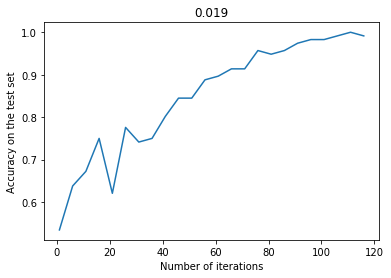

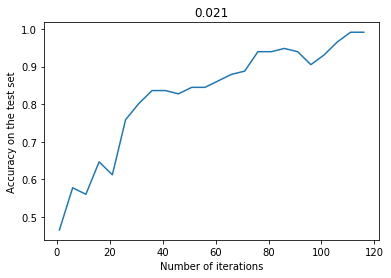

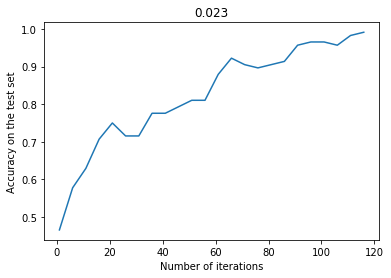

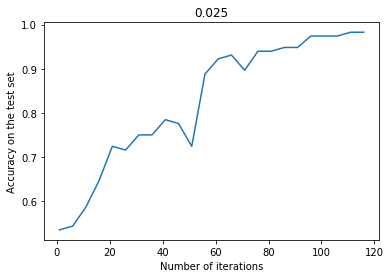

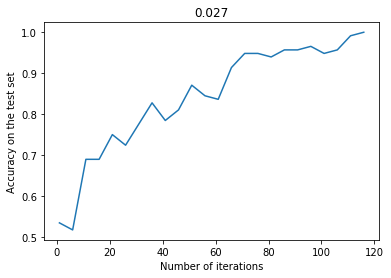

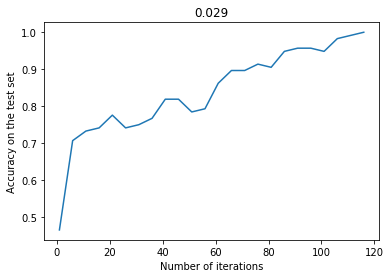

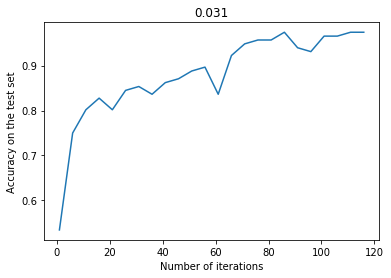

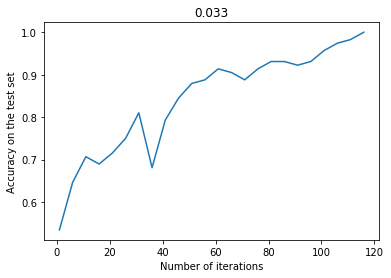

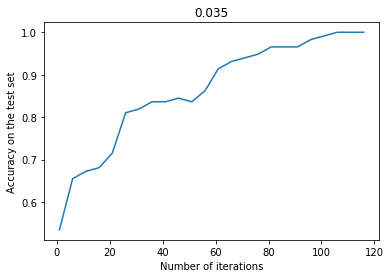

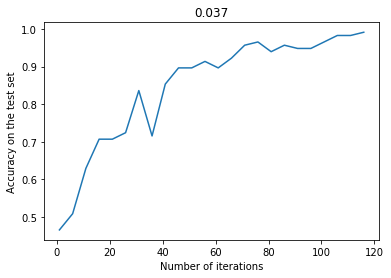

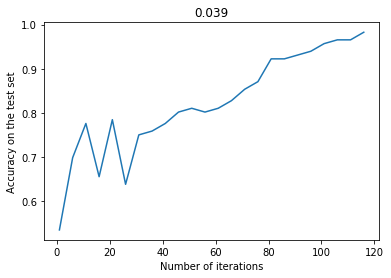

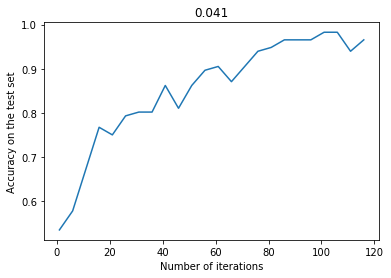

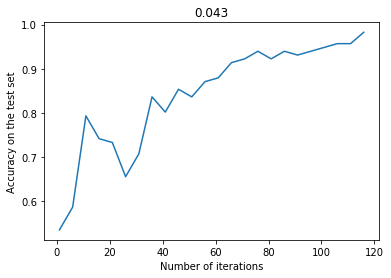

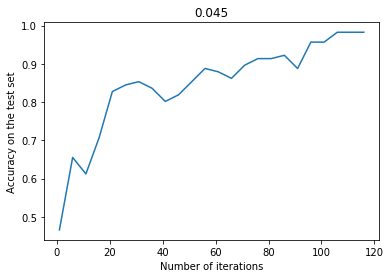

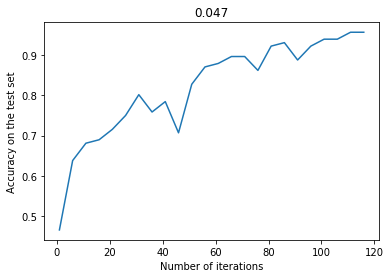

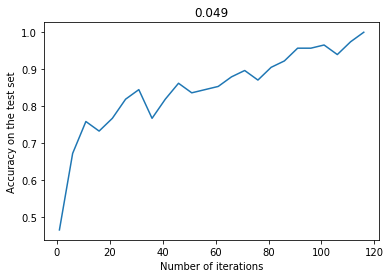

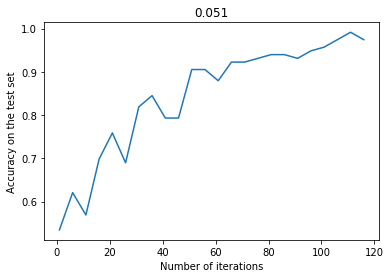

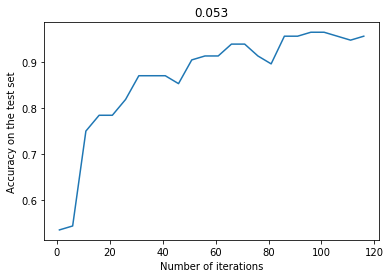

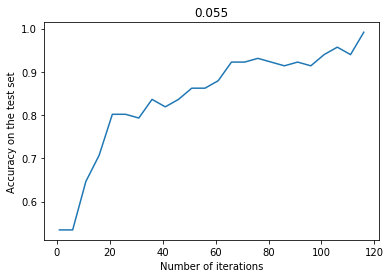

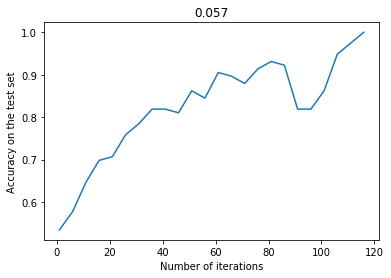

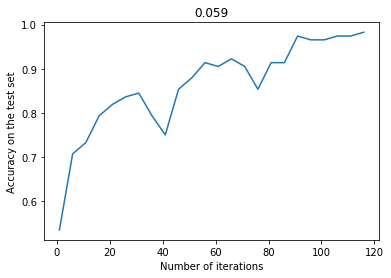

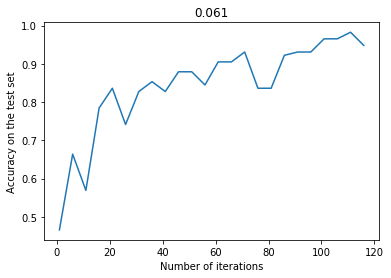

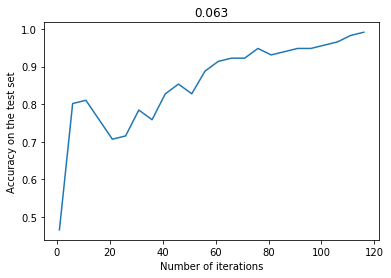

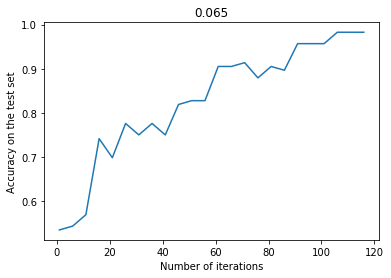

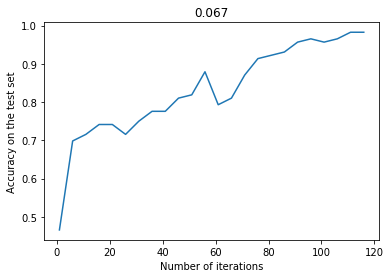

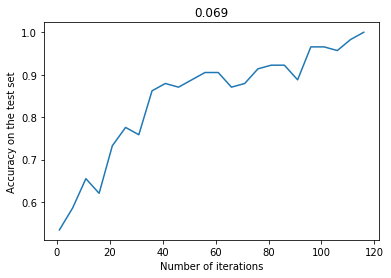

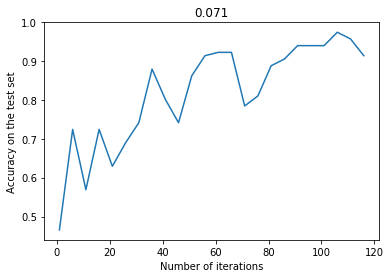

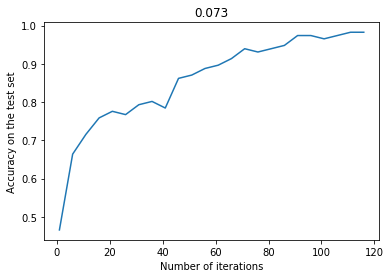

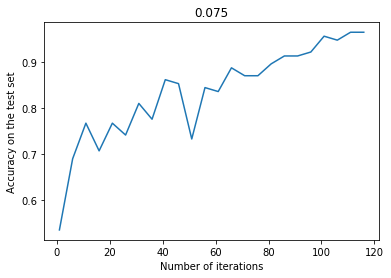

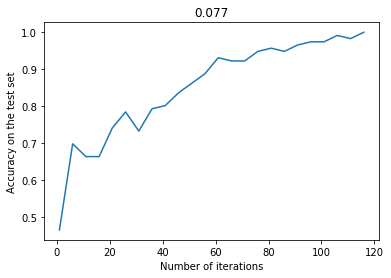

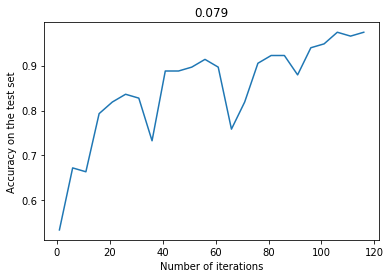

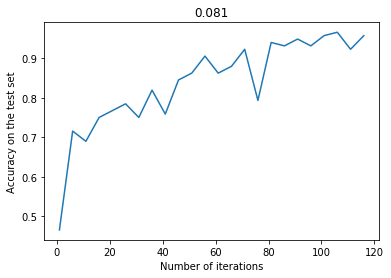

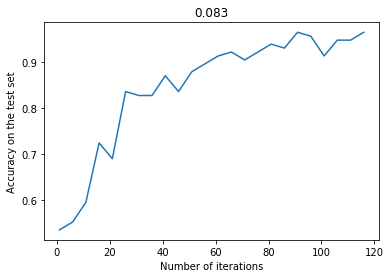

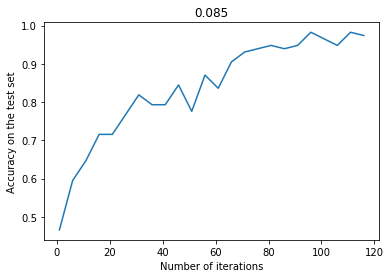

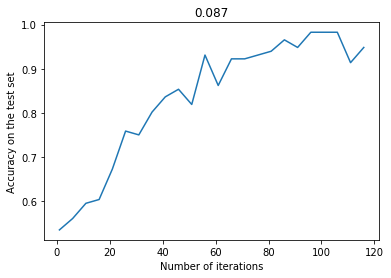

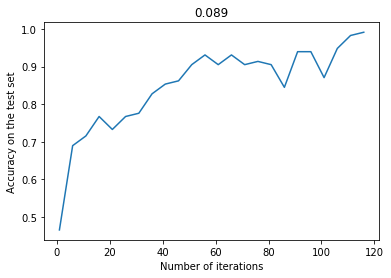

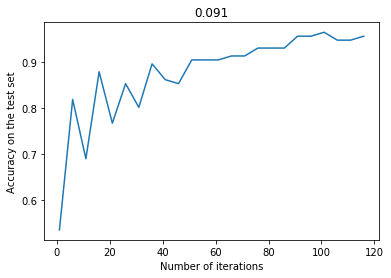

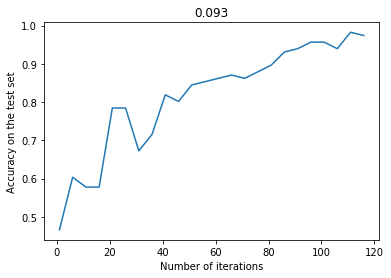

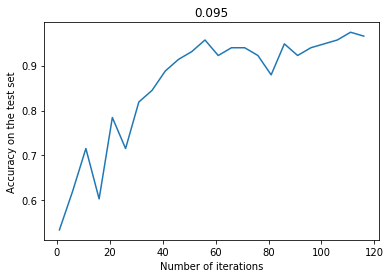

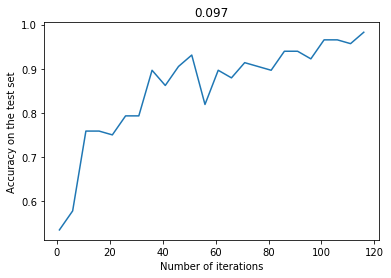

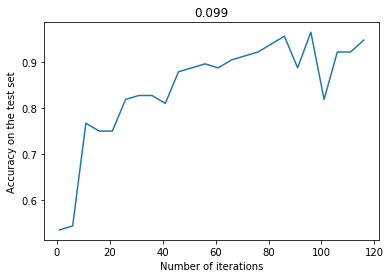

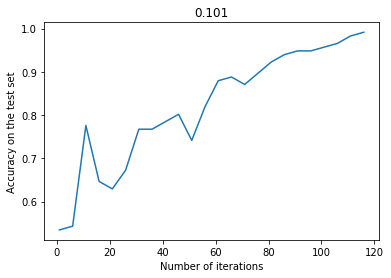

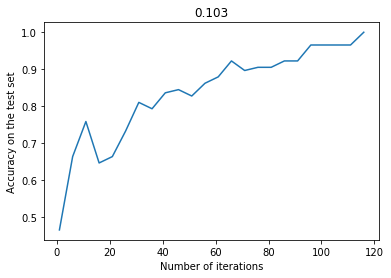

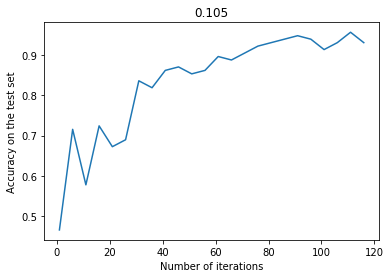

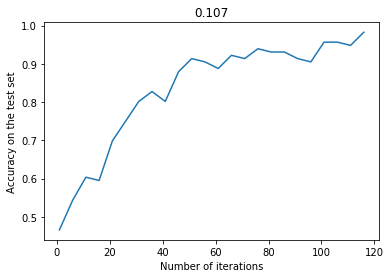

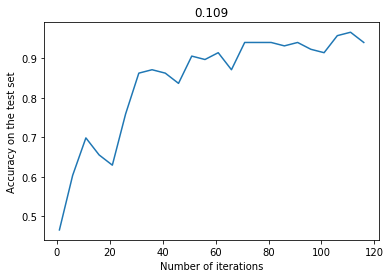

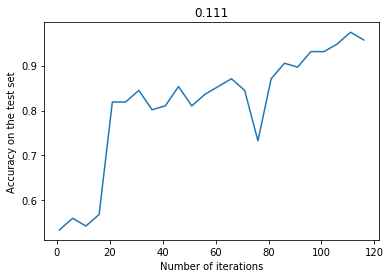

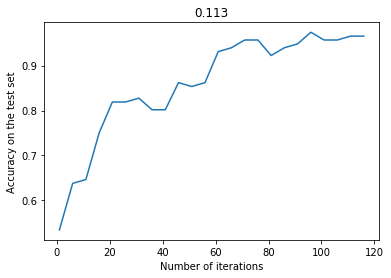

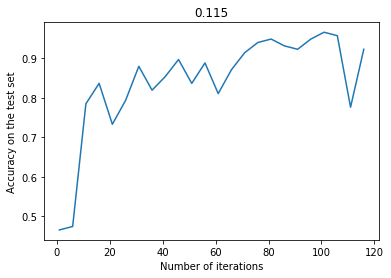

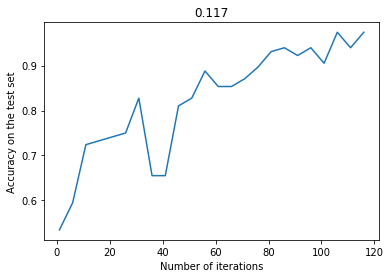

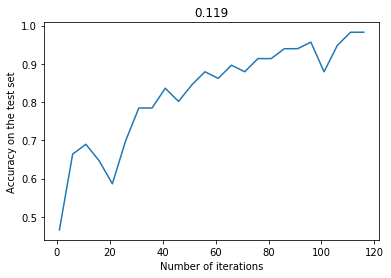

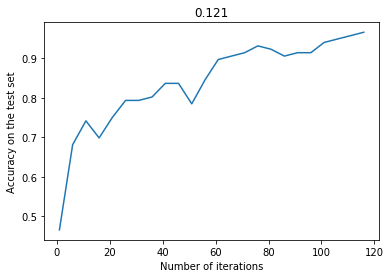

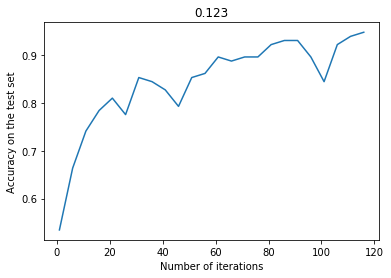

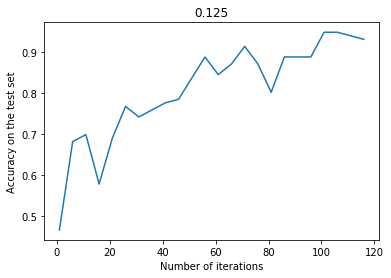

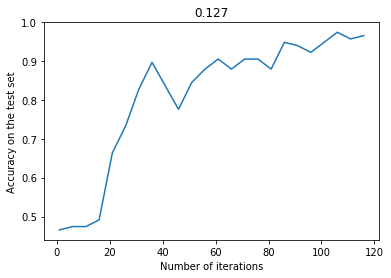

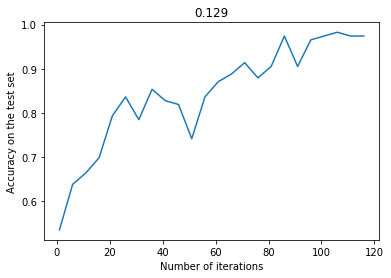

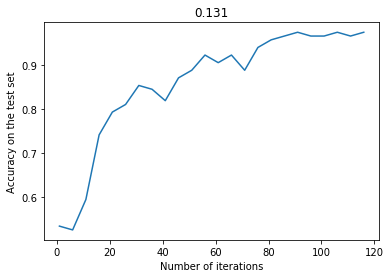

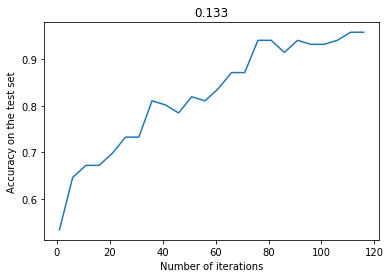

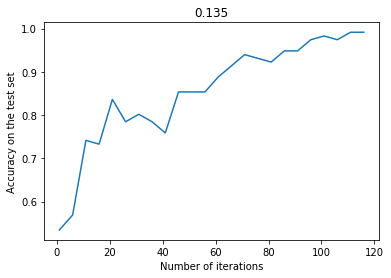

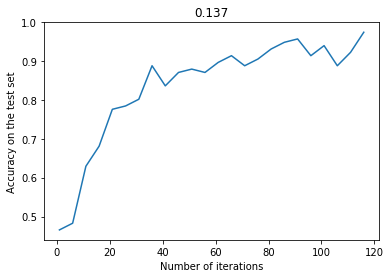

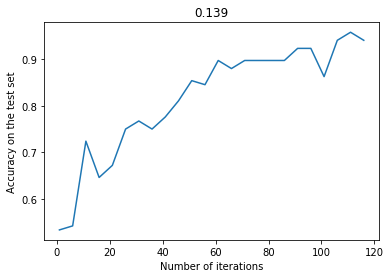

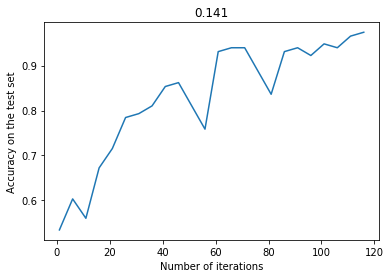

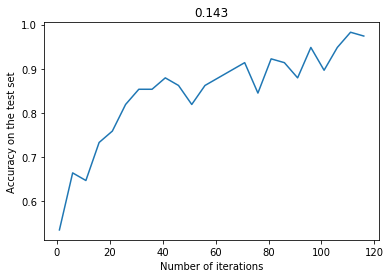

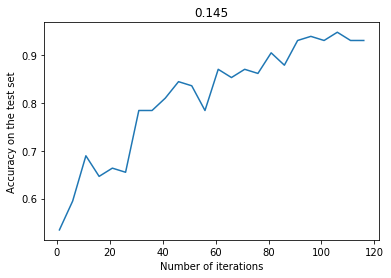

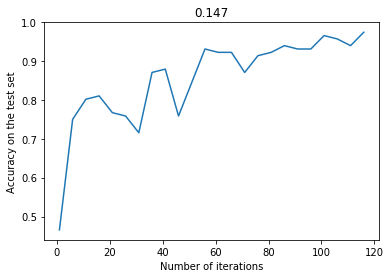

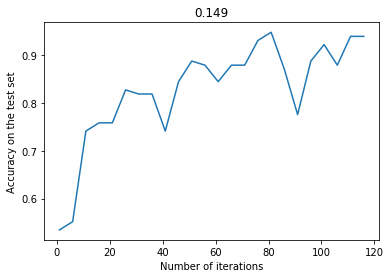

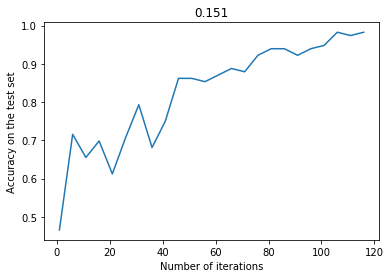

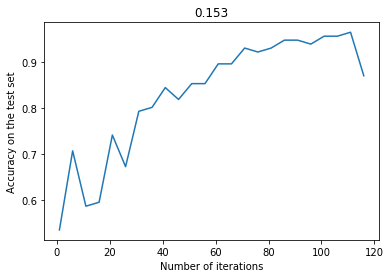

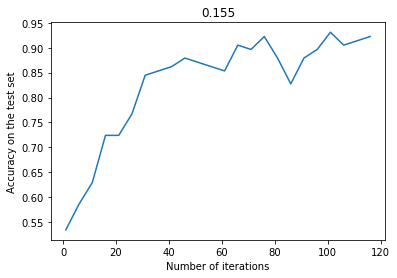

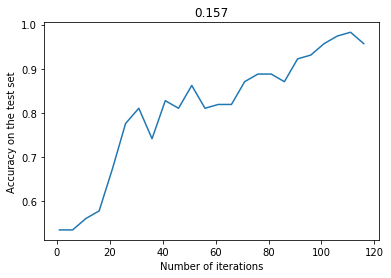

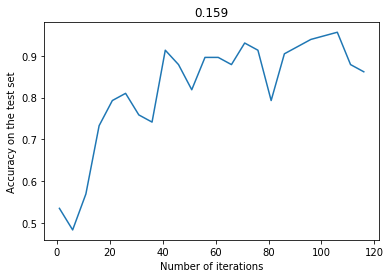

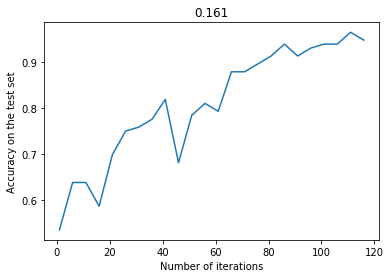

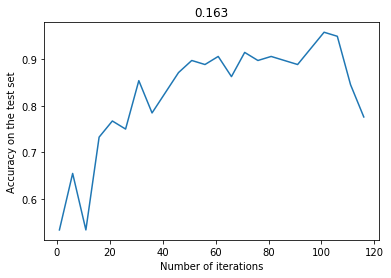

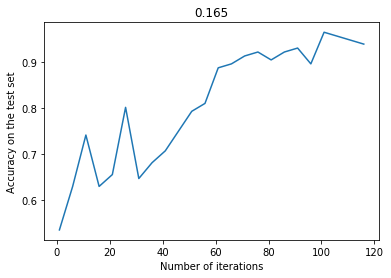

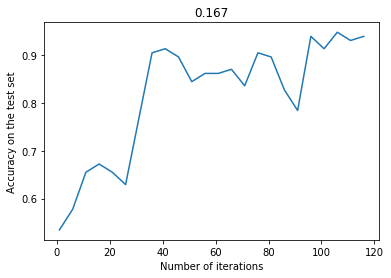

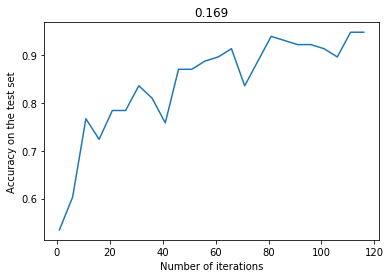

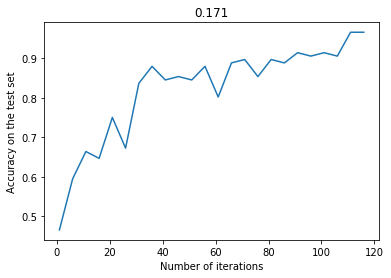

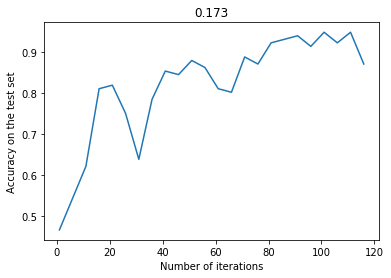

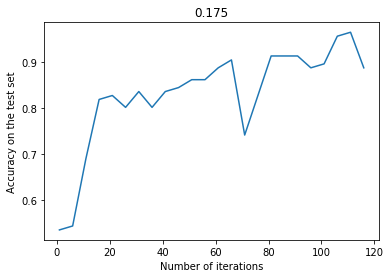

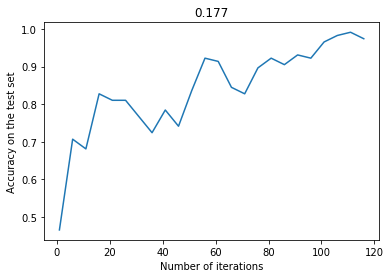

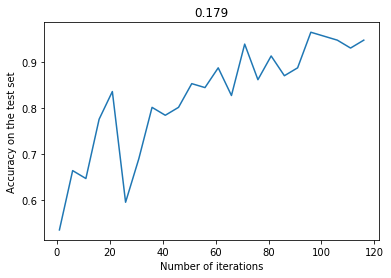

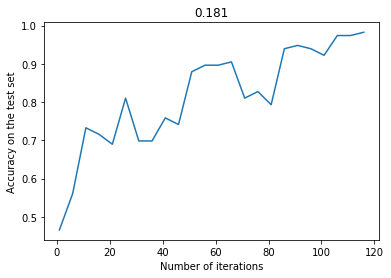

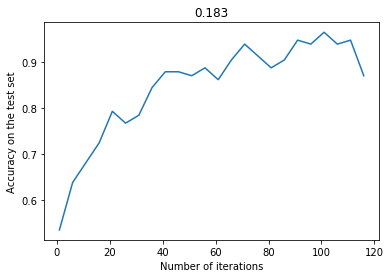

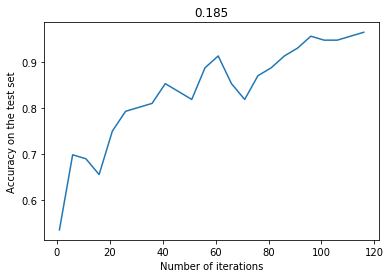

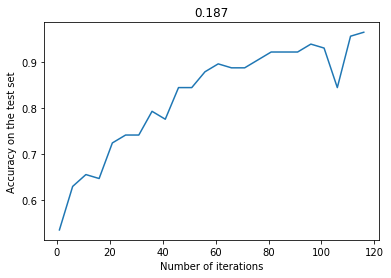

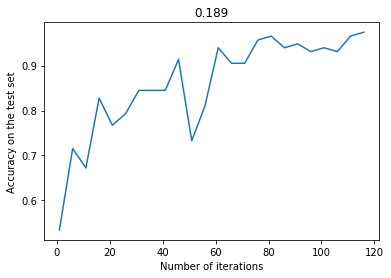

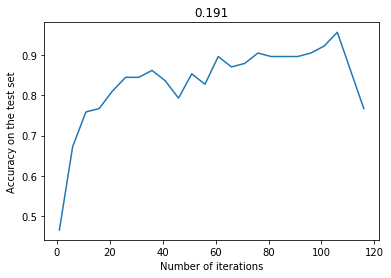

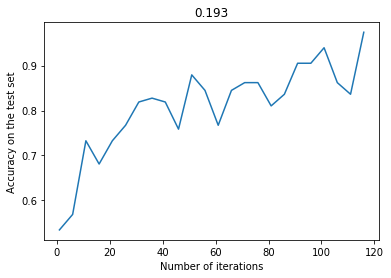

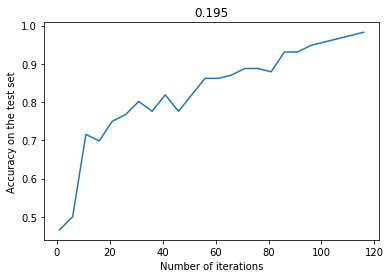

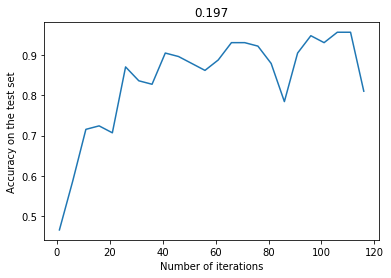

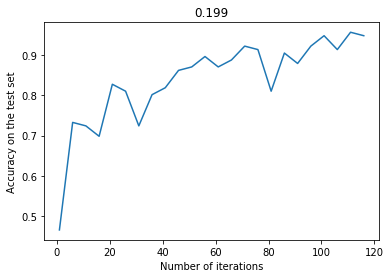

In [234]:
for lam in np.arange(0.001, 0.2, 0.002):
    lr = LogReg(train_set, test_set, lam, eta=0.1)
    lr.tester(isVerbose=False)
    plt.title(lam)
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy on the test set")
    plt.plot(lr.iterationcount,lr.test_acc)
    plt.show()

**Comments for Part A:** From the plots generated above for studying the effect of the regularization parameter on the accuracy of your classifier on the test set, we can conclude that the choice of $\lambda$ that seems to do the best is $\lambda$ = 0.107, since<br>
(1) it shows the least fluctuations in the accuracy, <br>
(2) the accuracy reaches as close to 1 as possible without touching 1 - so it does not overfit the data.

**Part B**: For the value of `lam` chosen in **Part A** perform a systematic study of the choice of learning rate on the speed of convergence SGD.  Which learning rate seems to give the fastest convergence?  Justify your conclusion with some kind of graphic. 

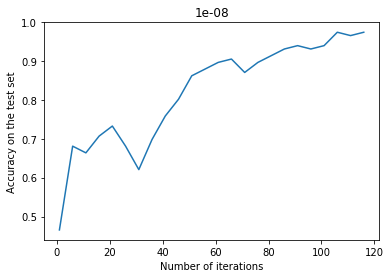

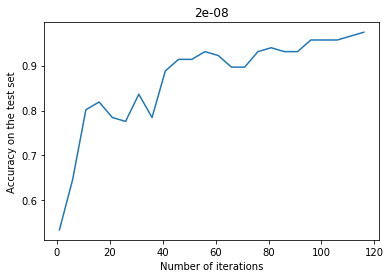

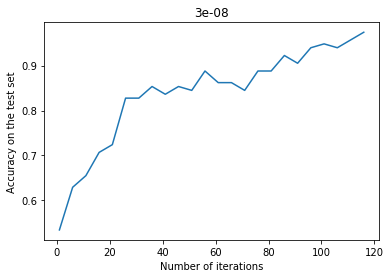

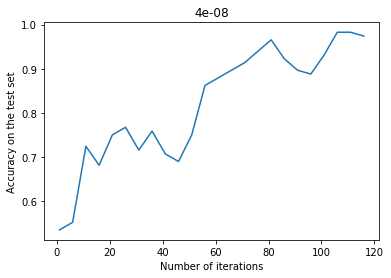

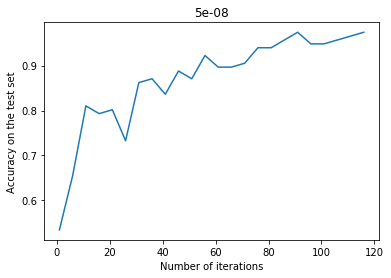

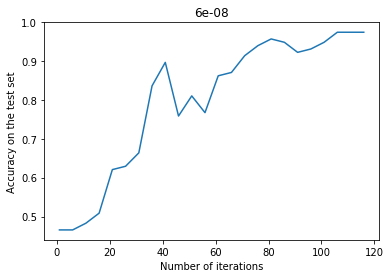

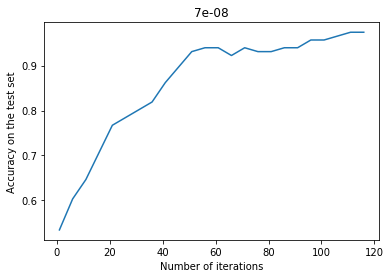

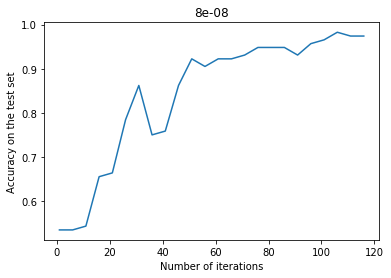

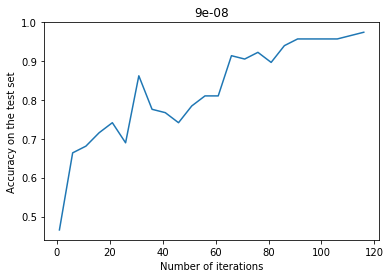

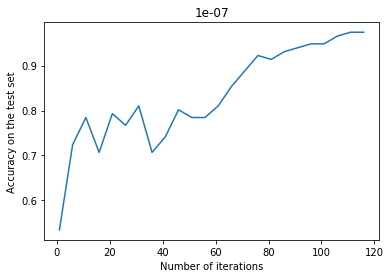

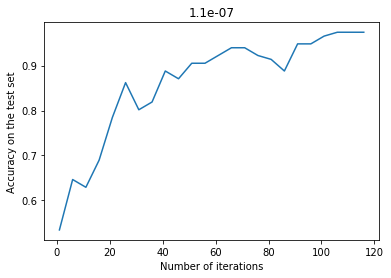

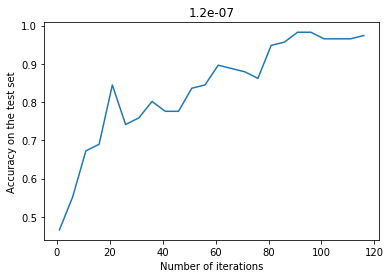

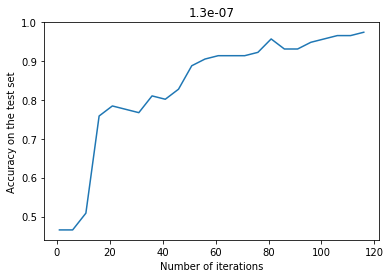

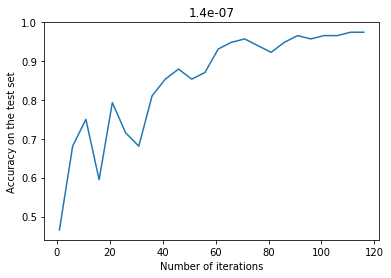

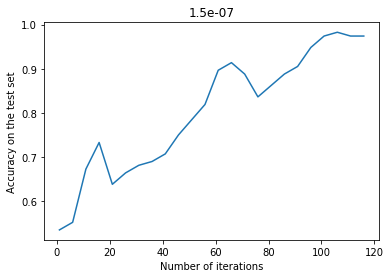

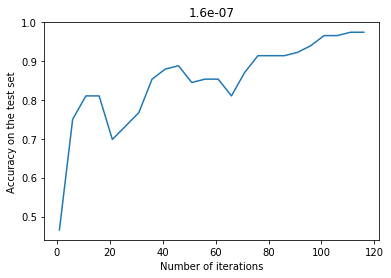

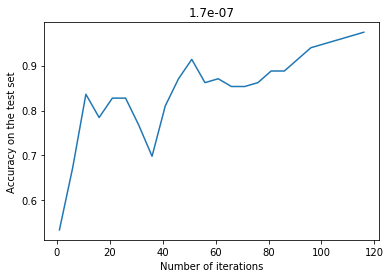

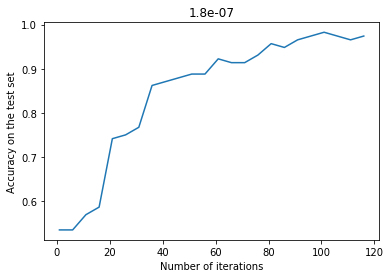

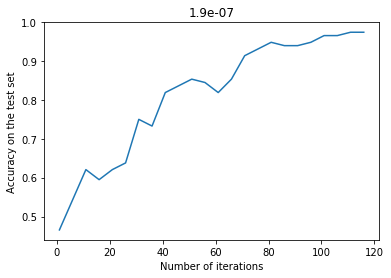

In [235]:
for etavalue in np.arange(0.00000001, 0.0000002, 0.00000001):
    lr = LogReg(train_set, test_set, lam=0.107, eta=etavalue)
    lr.tester(isVerbose=False)
    plt.title(etavalue)
    plt.xlabel("Number of iterations")
    plt.ylabel("Accuracy on the test set")
    plt.plot(lr.iterationcount,lr.test_acc)
    plt.show()

**Comments for Part B:** From the plots generated above for investigating the effect of learning rate on the speed of convergence SGD, the learning rate seems to give the fastest convergence is $\eta$ = 7e-08.

### [10 points] Problem 4: Identifying Predictive and Non-Predictive Words 
***

**Part A**: Find the top 10 words that are the best predictors for each class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [236]:
#Code for finding the best predictors for each class
print ("The best predictors for 'Motorcycle' class are: ")
bdm = lr.bestpredmotor()
for i in bdm:
    print(vocab[i])
print()
print ("The best predictors for 'Automobile' class are: ")
bda = lr.bestpredauto()
for j in bda:
    print(vocab[j])

The best predictors for 'Motorcycle' class are: 
helmet
side
ride
bikes
large
insurance
got
dog
dod
bike

The best predictors for 'Automobile' class are: 
car
cars
convertible
oil
engine
also
teenagers
price
fast
dealer


**Comments for Part A: ** (Mathematical explanation for finding the best predictors for each class) To find the top 10 words that are the best predictors for the 'Motorcycle' class, the weight vector was sorted in ascending order, and then the words for those weights were fetched from the vocabulary. Similarly, to find the top 10 words that are the best predictors for the 'Automobile' class, the weight vector was sorted in descending order, and the words for those weights were fetched from the vocabulary. 

**Part B**: Find the 10 words that are the worst predictors for class.  Explain mathematically how you identified them and show any code that you used to find them. 

In [237]:
#Code for finding the worst predictors for any class
print ("The worst predictors for any class are: ")
wp = lr.worstpred()
for k in wp:
    print(vocab[k])

The worst predictors for any class are: 
june
supposedly
severely
benefit
random
controlled
ft
ding
peeing
officers


**Comments for Part B: ** (Mathematical explanation for finding the worst predictors for any class) To find the top 10 words that are the worst predictors for any class, we need to find those words whose probabilities are as close to 0 as possible, which implies that these words are neither in the training nor the test set. To do this, the weight vector was again sorted in descending order, for the absolute values this time. This is equivalent to picking out those values lying in the middle in the weight vector when it is sorted either in ascending or descending order.